# Clustering RGB image features with PhenoGraph

#### This notebook uses the matrix of 672 features per single cell RGB cropped image to cluster the cells and identify which are red blood cells based on clustering pattern

## Importing

In [1]:
import warnings
# To ignore Pandas Future Warning
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import phenograph
import copy
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
%matplotlib inline

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
print("phenograph==", phenograph.__version__)
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7
phenograph== 1.5.7


In [3]:
from os import listdir
from os.path import isfile, join

### Read in feature matrix as csv

In [4]:
pt = 'P51'

In [5]:
# read in features from each fov
feats_dir = 'Normalized_RGB_feats/'
tables = [f for f in listdir(feats_dir) if isfile(join(feats_dir, f))]
tables.sort()

In [6]:
# create all-fov feats table
all_fovs = pd.read_csv(feats_dir + tables[0], index_col=0)

for i in range(1,len(tables)):
    data = pd.read_csv(feats_dir + tables[i], index_col=0)
    all_fovs = pd.concat([all_fovs, data])
    
all_fovs

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
P51_FOV01_cell_1,0.402802,2.519914,3.102974,2.532820,0.563197,0.400669,2.261167,-0.155384,0.772644,0.302963,...,0.485197,0.061834,0.076273,0.026249,1.749596,0.171673,3.464388,-0.082069,0.682078,-0.028150
P51_FOV01_cell_2,0.388976,2.487458,3.078787,2.488903,0.586997,0.428440,2.279656,-0.154442,0.756440,0.323747,...,0.491818,0.072046,0.227359,0.037253,1.768932,0.181624,3.474304,-0.076829,0.622389,-0.000044
P51_FOV01_cell_3,0.380482,2.529548,3.053570,2.483068,0.569946,0.528408,2.280724,-0.139854,0.826169,0.370398,...,0.497272,-0.001452,0.304065,0.058150,1.758170,0.219478,3.474680,-0.036864,0.566432,-0.024347
P51_FOV01_cell_4,0.403217,2.458258,3.104902,2.334026,0.667799,0.506018,2.229501,-0.118787,0.839736,0.618872,...,0.494580,0.192768,0.301545,0.065818,1.834521,0.326531,3.400238,0.009931,0.488011,0.004267
P51_FOV01_cell_5,0.451230,2.502557,3.096735,2.526596,0.557576,0.434876,2.308490,-0.151681,0.784866,0.368900,...,0.518730,0.132573,0.054450,0.014751,1.746402,0.178451,3.477299,-0.035469,0.614253,0.012709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P51_FOV22_cell_6750,0.424042,2.608087,3.116840,2.684880,0.555995,0.428599,2.367165,-0.147590,0.802694,0.315504,...,0.543899,-0.027317,0.167454,-0.026442,1.771294,0.165081,3.407572,0.131377,0.594620,-0.061437
P51_FOV22_cell_6751,0.418256,2.664149,3.121941,2.710535,0.563525,0.384561,2.335695,-0.110081,0.824351,0.284899,...,0.525468,-0.044900,0.223227,-0.009176,1.738339,0.164092,3.438738,-0.000527,0.648478,-0.046256
P51_FOV22_cell_6752,0.422037,2.743563,3.100204,2.705849,0.572294,0.375778,2.321158,-0.052463,0.887149,0.287756,...,0.541117,-0.049455,0.257946,-0.012321,1.724418,0.167267,3.430040,-0.025092,0.625651,-0.059810
P51_FOV22_cell_6754,0.404622,2.629574,3.158504,2.666598,0.536229,0.396908,2.338999,-0.153600,0.780912,0.278141,...,0.509183,-0.038781,0.194271,0.004003,1.743908,0.153495,3.460380,-0.052636,0.638385,-0.046041


In [7]:
# concatenate individual FOV feature tables as 1 large feature table
all_fovs.to_csv(pt + "_all_cell_RGB_features.csv", header=False)

In [8]:
# read in feature matrix as anndata object for clustering
adata = sc.read_csv(pt + "_all_cell_RGB_features.csv", first_column_names=True)
adata

AnnData object with n_obs × n_vars = 70539 × 672

In [9]:
adata.obs

""
P51_FOV01_cell_1
P51_FOV01_cell_2
P51_FOV01_cell_3
P51_FOV01_cell_4
P51_FOV01_cell_5
...
P51_FOV22_cell_6750
P51_FOV22_cell_6751
P51_FOV22_cell_6752
P51_FOV22_cell_6754


In [10]:
# load FOV metadata
FOV_metadata = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/FOV_metadata.csv', index_col=0)
FOV_metadata

,Timepoint,Clinical outcome
P51_FOV01,A,PD
P51_FOV02,A,PD
P51_FOV03,A,PD
P51_FOV04,A,PD
P51_FOV05,A,PD
...,...,...
P58_FOV19,C,SD
P58_FOV20,C,SD
P58_FOV21,C,SD
P58_FOV22,C,SD


In [11]:
# get FOV and cell number from cell ID o

adata.obs['FOV'] = ''
adata.obs['cell_ID'] = 0
adata.obs['Timepoint'] = ''

for i in range(adata.obs.shape[0]):
    adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
    adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')
    adata.obs['Timepoint'].iloc[i] = FOV_metadata['Timepoint'].loc[adata.obs.iloc[i].name[0:9]]

adata.obs

/tmp/ipykernel_1341136/4186933571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
/tmp/ipykernel_1341136/4186933571.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')


,FOV,cell_ID,Timepoint
P51_FOV01_cell_1,01,1,A
P51_FOV01_cell_2,01,2,A
P51_FOV01_cell_3,01,3,A
P51_FOV01_cell_4,01,4,A
P51_FOV01_cell_5,01,5,A
...,...,...,...
P51_FOV22_cell_6750,22,6750,C
P51_FOV22_cell_6751,22,6751,C
P51_FOV22_cell_6752,22,6752,C
P51_FOV22_cell_6754,22,6754,C


In [12]:
# save copy of complete anndata object
adata_all = adata

## Cluster Timepoint A FOVs for RBCs

In [13]:
tp = 'A'

In [14]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 16449 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [15]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [16]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

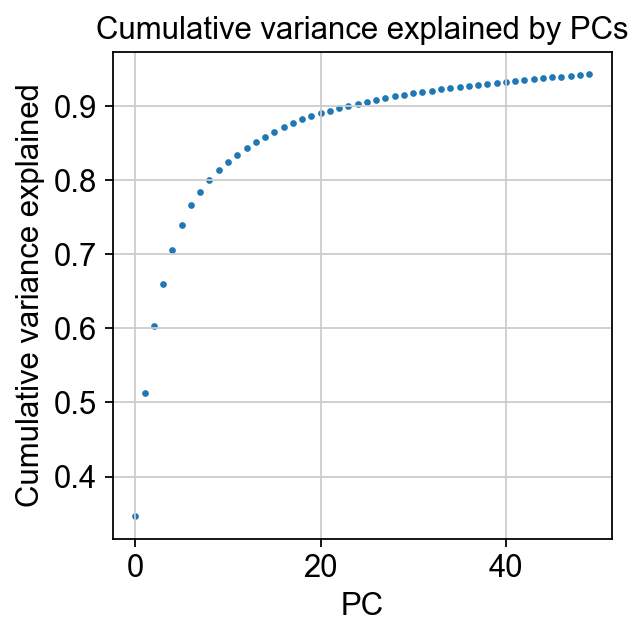

In [17]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [18]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [26]:
k = 25 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 25 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 5.837071657180786 seconds
Jaccard graph constructed in 6.012065410614014 seconds
Wrote graph to binary file in 0.14284920692443848 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.755142
After 5 runs, maximum modularity is Q = 0.756556
After 16 runs, maximum modularity is Q = 0.757951
Louvain completed 36 runs in 12.929011344909668 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 26.950610637664795 seconds


In [27]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


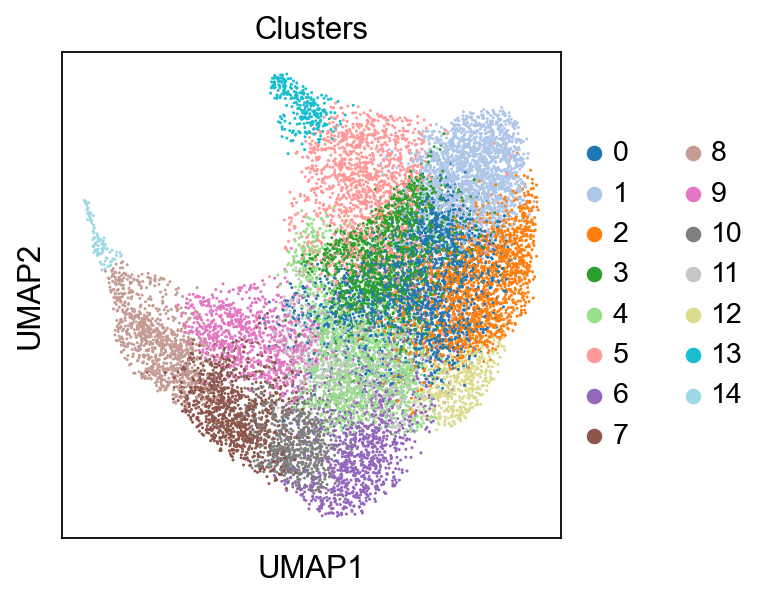

In [28]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


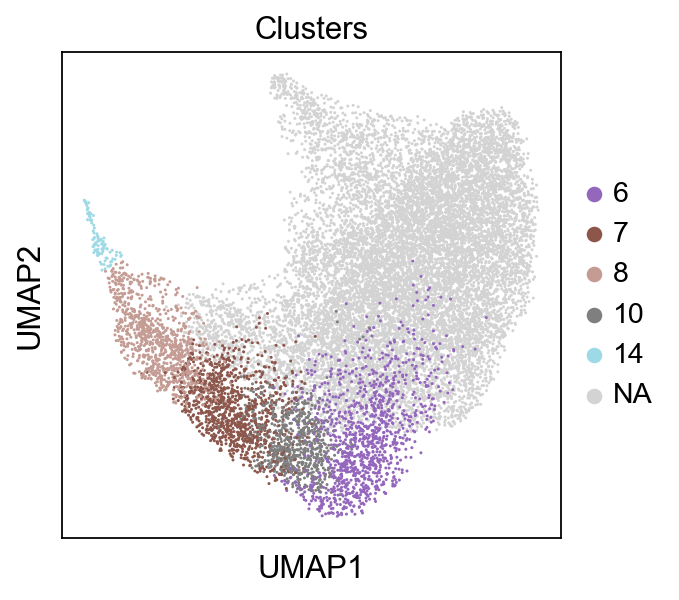

In [34]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[6,7,8,10,14]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


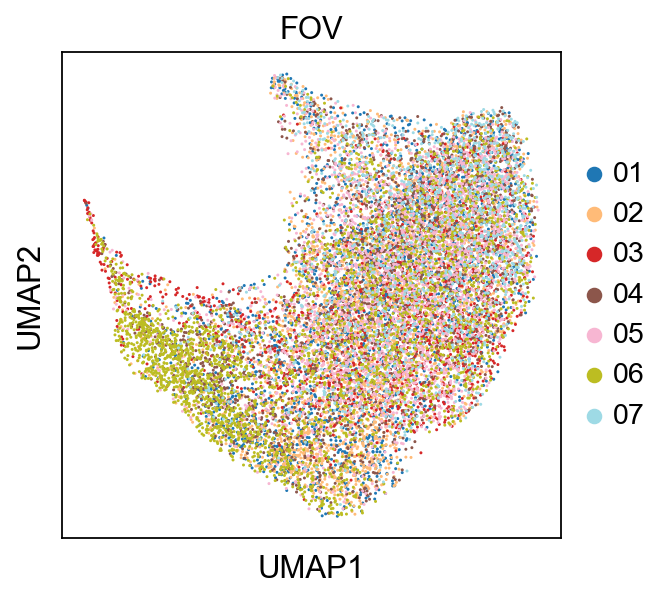

In [30]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [31]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [32]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')

## Cluster Timepoint B FOVs for RBCs

In [63]:
tp = 'B'

In [64]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 23470 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [65]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [66]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

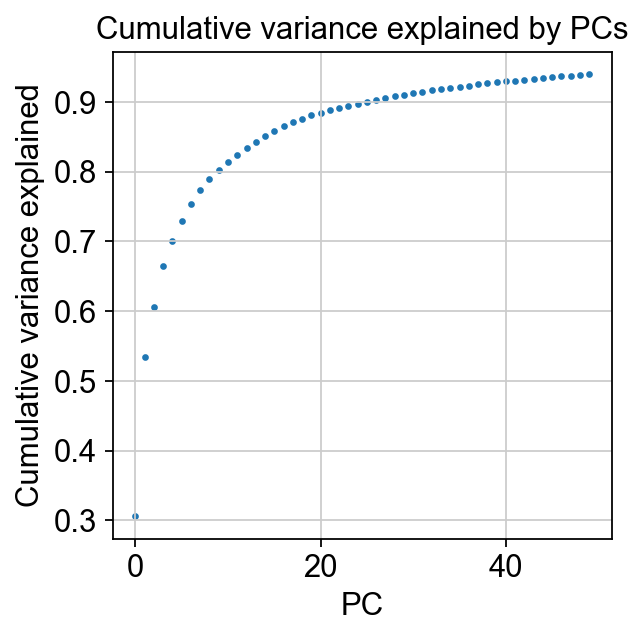

In [67]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [68]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [69]:
k = 10 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 11.614001750946045 seconds
Jaccard graph constructed in 3.7162246704101562 seconds
Wrote graph to binary file in 0.0738534927368164 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.811373
After 3 runs, maximum modularity is Q = 0.813775
Louvain completed 23 runs in 3.5482583045959473 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 20.733257055282593 seconds


In [70]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


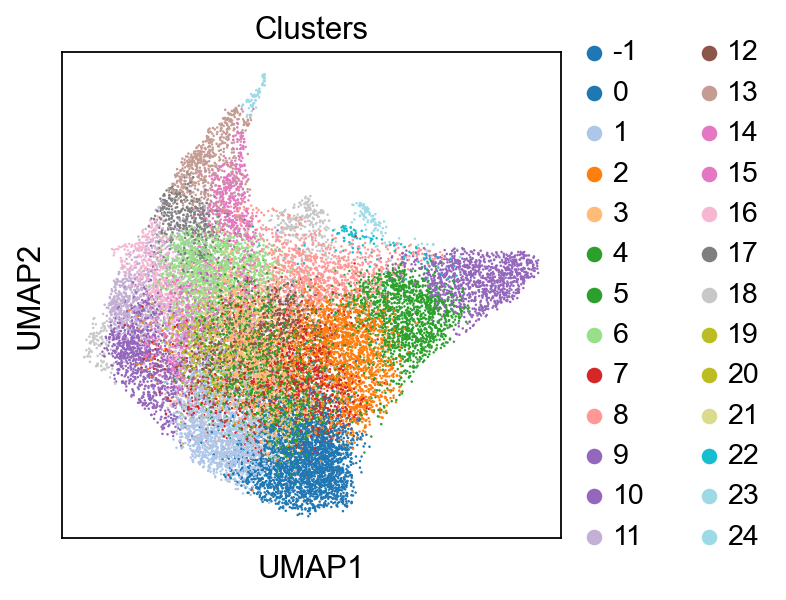

In [72]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


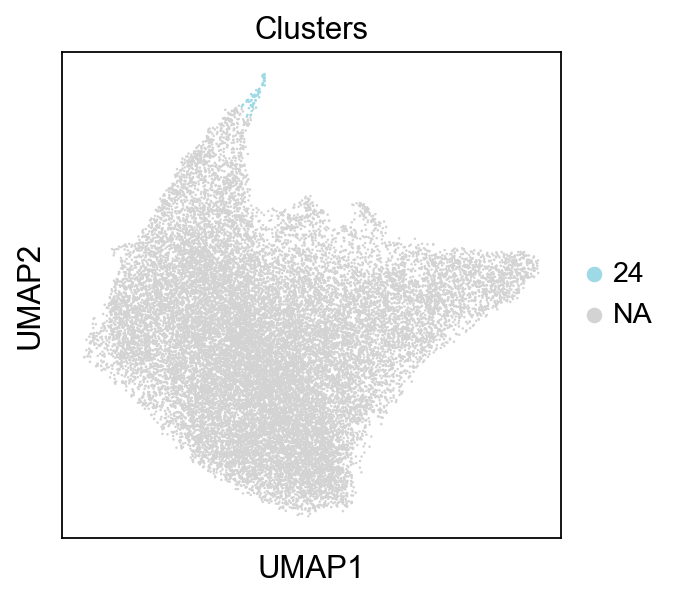

In [84]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[24]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


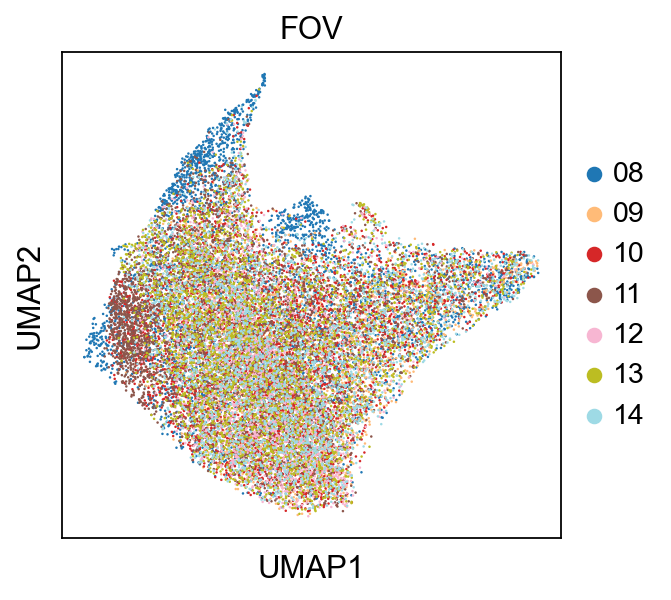

In [78]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [79]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [80]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')

## Cluster Timepoint C FOVs for RBCs

In [85]:
tp = 'C'

In [86]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 30620 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [87]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [88]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

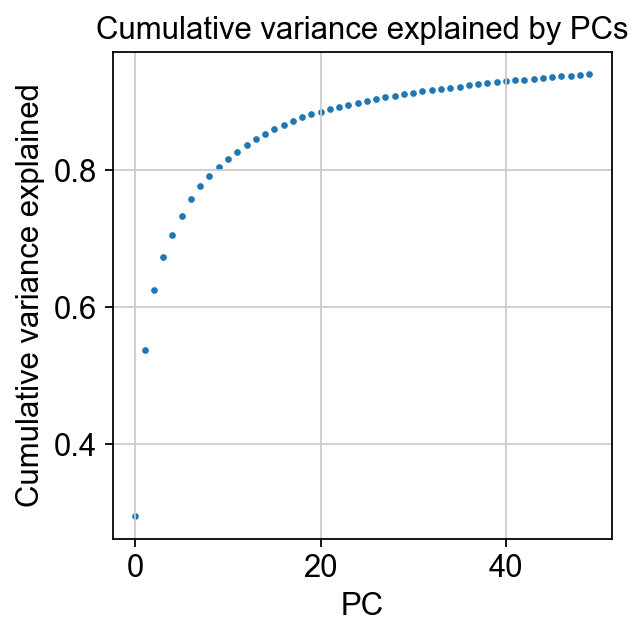

In [89]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [90]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [91]:
k = 15 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 23.4059636592865 seconds
Jaccard graph constructed in 9.529489040374756 seconds
Wrote graph to binary file in 0.2571578025817871 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.773843
Louvain completed 21 runs in 10.27088475227356 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 45.3800585269928 seconds


In [92]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


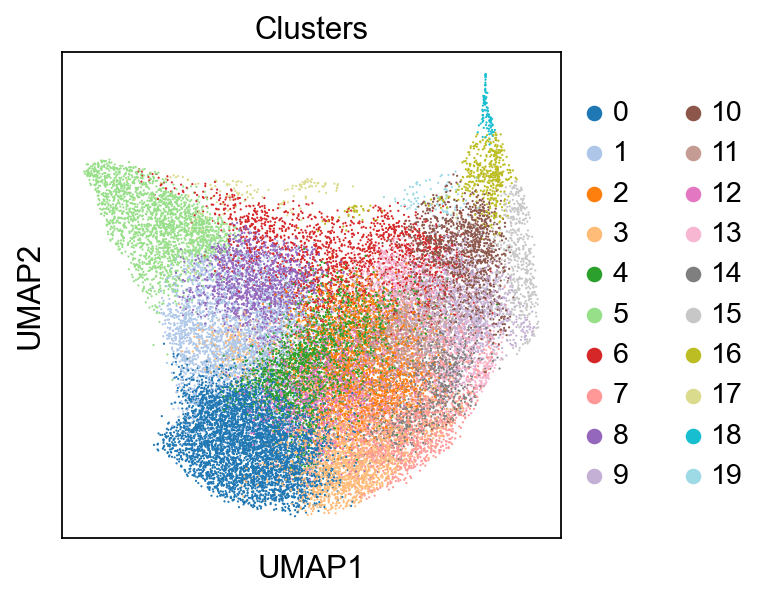

In [94]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


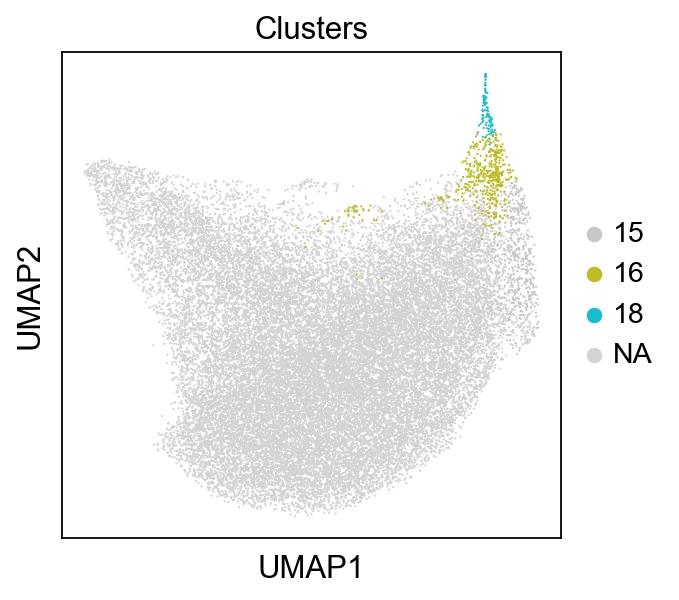

In [100]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[15,16,18]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


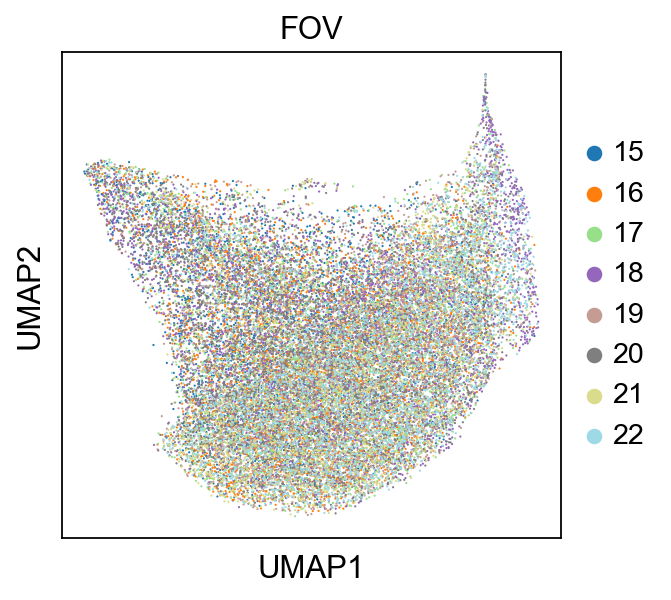

In [96]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [97]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [98]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')